In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl

In [3]:
with open("shuttle.trn","r") as f:
    all_lines = f.read()
    
lines = all_lines.split('\n')
train = np.array([[float(n) for n in l.split(' ')] for l in lines[:-1]])

with open("shuttle.tst","r") as f:
    all_lines = f.read()
    
lines = all_lines.split('\n')
test = np.array([[float(n) for n in l.split(' ')] for l in lines[:-1]])

seed = 2
train = train[seed::3]
test = test[seed::3]
size = train.shape[0]

print(train.shape, test.shape)

c=0 # conditional variable index
numbers = np.concatenate([train,test])
numbers[:,c] = (np.argsort(numbers[:,c].flatten()).argsort()/numbers[:,c].size).reshape(numbers[:,c].shape)
train = numbers[:size]
test = numbers[size:]
print(train.shape, test.shape)

(14500, 10) (4833, 10)
(14500, 10) (4833, 10)


In [4]:
import sys
sys.path.insert(0, '/home/nina/CopulaGP/')
from marginal import heuristic_element_order
order = heuristic_element_order(numbers) # different for test, but we follow the vine.R by Hernandez-Lobato
order

array([7, 4, 9, 8, 0, 6, 2, 5, 1, 3])

In [5]:
import marginal as mg
X = train[:,c]
Xt = test[:,c]
Y_raw = train[:,order[order!=c]]
Yt_raw = test[:,order[order!=c]]
# conditional
Y = np.zeros_like(Y_raw)
Yt = np.zeros_like(Yt_raw)
for i, (y,yt) in enumerate(zip(Y_raw.T,Yt_raw.T)):
    Y[:,i] = mg.fast_signal2uniform(y,X)
    Yt[:,i] = mg.fast_signal2uniform(y,X,Y_=yt,X_=Xt)
    print(i)
# unconditional
# Y = Y_raw
# Yt = Yt_raw

/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/fastkde/fastKDE.py:775: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dxProd = dxProd[cslice[::-1]]


0
1
2
3
4
5
6
7
8


In [6]:
import MI
Hs = []
for i in range(1,9):
    _,H = MI.BI_KSG(numbers[:,0].reshape(-1,1),numbers[:,i].reshape(-1,1))
    print(H)
    Hs.append(H)

-7.420557874968377
-4.203508964679052
-7.29818629924711
-7.084938963639161
-2.557310070640135
-4.046568174837203
-2.2781650372375735
-6.851544081473325


(14500,)

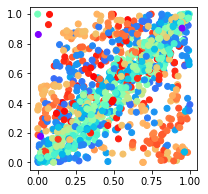

In [7]:
import matplotlib.cm as cm

plt.figure(figsize=(3,3))
skip = 4
plt.scatter(*Yt[::skip,[0,4]].T,color=cm.rainbow(Xt[::skip]))
X.shape

In [8]:
X.max()

0.9999482749702581

In [9]:
def normalize_Y(Y_all,min,max):
    return (Y_all - min)/(max-min)*0.998+0.001
d = {}
d['X'] = X
d['Xt'] = Xt
min = np.concatenate([Y,Yt]).min(0)
max = np.concatenate([Y,Yt]).max(0)
d['Y'] = normalize_Y(Y,min,max)
d['Yt'] = normalize_Y(Yt,min,max)
d['X_label'] = 'latitude'
# d['Y_labels'] = [] #TODO 
d['comment'] = 'All variables were sorted together (emp. kendalls tau), \
                    thenlatitude moved to the first position'

# here only keys X and Y are standard. The rest will be ignored by training code

with open(f"/home/nina/CopulaGP/examples/shuttle/outputs/shuttle{seed}_layer0.pkl",'wb') as f:
    pkl.dump(d,f)

now go and train it

In [12]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

seed=2

with open(f"/home/nina/CopulaGP/examples/shuttle/outputs/shuttle{seed}G_trained.pkl","rb") as f:
    trained = pkl.load(f)

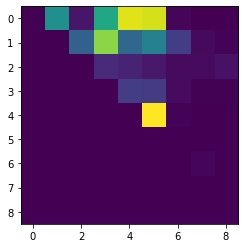

In [13]:
NN = len(trained['waics'][0])+1
WAICs = np.zeros((NN,NN))
for layer, ws in enumerate(trained['waics']):
    WAICs[layer,(layer+1):] = [-a for a in ws]
plt.imshow(WAICs[:])

In [8]:
device = "cuda:0"

with open(f"/home/nina/CopulaGP/examples/shuttle/outputs/shuttle{seed}_layer0.pkl","rb") as f:
    d = pkl.load(f)

#real
train_x = torch.tensor(d['X'], device=device).float()
train_y = torch.tensor(d['Y'], device=device).float()
test_x = torch.tensor(d['Xt'], device=device).float()
test_y = torch.tensor(d['Yt'], device=device).float()

# N_points=test_x.shape[0]

In [14]:
from vine import CVine
vine_base = CVine.marginalize(trained['models'],test_x,device=device)

In [15]:
vine = vine_base.truncate(5)
copgpT = vine.log_prob(test_y).mean()
copgp = vine_base.log_prob(test_y).mean()
(copgp,copgpT)
# X.shape

(tensor(3.8260, device='cuda:0'), tensor(2.8692, device='cuda:0'))

In [180]:
#redirect logging here
def train4entropy(x,y,xt,likelihood,shuffle=False):
    Nvar = y.shape[-1]
    data_layers = [torch.tensor(y).clamp(0.001,0.999).float().to(device)]
    copula_layers, model_layers = [], []
    for m in range(0,Nvar-1):
        copulas, layer, models = [], [], []
        for n in range(1,Nvar-m):
            print(m,n+m)
            if shuffle:
                x = x[torch.randperm(NSamp)]
            samples = data_layers[-1][...,[n,0]]
            waic, model = bvcopula.infer(likelihood,x,samples,device=device) 
            print(f'WAIC: {waic}')
            if shuffle:
                x = x[torch.randperm(NSamp)]
            with torch.no_grad():
                f = model(x).mean
                copula = model.likelihood.get_copula(f)
                layer.append(copula.ccdf(samples))
                models.append(model)
                
                ft = model(xt).mean
                copulat = model.likelihood.get_copula(ft)
                copulas.append(copulat)
        data_layers.append(torch.stack(layer,dim=-1))
        copula_layers.append(copulas)
        model_layers.append(models)
    print('Trained')
    vine_trained = CVine(copula_layers,xt,device=device)
#     entropies = vine_trained.entropy(sem_tol=0.1, mc_size=1000, v=True)
    return copula_layers, model_layers, vine_trained#, entropies

In [151]:
likelihood = [bvcopula.GaussianCopula_Likelihood()]
%time copula_layers, models, vine = train4entropy(train_x,train_y,test_x,likelihood, shuffle=False)

/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


0 1
WAIC: -0.2910406291484833
0 2
WAIC: -0.022177960723638535
0 3
WAIC: -0.24528378248214722
0 4
WAIC: -0.5649643540382385
0 5
WAIC: -0.49136149883270264
0 6
WAIC: -0.003698203479871154
0 7
WAIC: -0.0017108517931774259
0 8
WAIC: -0.00025834262487478554
1 2
WAIC: -0.254146009683609
1 3
WAIC: -0.24017022550106049
1 4
WAIC: -0.23091907799243927
1 5
WAIC: -0.24927978217601776
1 6
WAIC: -0.14193055033683777
1 7
WAIC: -0.036047354340553284
1 8
WAIC: -0.0005853186012245715
2 3
WAIC: -0.34637442231178284
2 4
WAIC: -0.055983223021030426
2 5
WAIC: -0.05516083538532257
2 6
WAIC: -0.02970758080482483
2 7
WAIC: -0.1384006291627884
2 8
WAIC: -0.005632654298096895
3 4
WAIC: -0.07367432117462158
3 5
WAIC: -0.037610962986946106
3 6
WAIC: -0.028000326827168465
3 7
WAIC: -0.03234613686800003
3 8
WAIC: -0.00023477528884541243
4 5
WAIC: -0.6243498921394348
4 6
WAIC: -0.005916230380535126
4 7
WAIC: -0.0013180077075958252
4 8
WAIC: -0.0008425269625149667
5 6
WAIC: -0.0037598260678350925
5 7
WAIC: -0.00079781

In [153]:
vine = CVine(copula_layers,test_x,device=device).truncate(5)
logprobT = vine.log_prob(test_y).mean()
vine = CVine(copula_layers,test_x,device=device)
logprob = vine.log_prob(test_y).mean()
(logprob,logprobT)

(tensor(3.8267, device='cuda:0'), tensor(3.0499, device='cuda:0'))

In [154]:
d['copula_layers'] = copula_layers
d['vine'] = vine 
d['copgp_logprob'] = copgp.item()
d['copgp_logprob_trunc5'] = copgpT.item() #cut 5 last layers, the same way as Hernandez-Lobato did in ICML
d['logprob'] = logprob.item()
d['logprob_trunc5'] = logprobT.item()
with open(f"res_shuttle{seed}.pkl","wb") as f:
    pkl.dump(d,f)

In [118]:
def report(arr):
    return f"{arr.mean():.3f}$\pm${arr.std():.3f}"

In [119]:
# np.array([3.1495,2.7663,2.7743]).mean() #weather col 3 (seed 42,43,44)
report(np.array([1.7590,1.5948,1.6253])) #weather col 3 T2 (seed 42,43,44,45)

'1.662$\\pm$0.062'

In [661]:
report(np.array([1.28,1.61,1.23])) #weather col 2
report(np.array([])) #weather col 2 T2

0.16858891488535727

In [ ]:
# np.array([2.176]).std() #weather col 1

In [186]:
#Mixture
report(np.array([5.3181,4.9605,5.0673])) #shuttle (shift 0,1,2, every 4th element of the original UCL dataset)
# report(np.array([4.5637,4.2347,4.1797])) #T3


'5.115$\\pm$0.150'

In [156]:
#Only Gauss
report(np.array([4.4774,3.8267,4.2878])) #shuttle
# report(np.array([3.7960,3.0499,3.3745])) #T3

'4.197$\\pm$0.273'

In [187]:
#Single
report(np.array([4.6135,4.1668,4.6301])) # shuttle
# report(np.array([4.1533,3.4038,3.7191])) # T3

'4.470$\\pm$0.215'